# Stock Prediction Model - Binary Classification

## Bài toán: Dự đoán tín hiệu MUA cổ phiếu
- **Target = 1**: Nên MUA (Future_Return_7d > 2%)
- **Target = 0**: KHÔNG MUA (Future_Return_7d ≤ 2%)

## Đặc điểm dữ liệu:
- Time series data theo từng mã cổ phiếu
- Cần chia train/test theo thời gian (không shuffle)
- Binary Classification: Tập trung vào tín hiệu MUA chất lượng cao
- Model: Random Forest & LightGBM Classifier

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import time
import warnings

from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,  roc_curve, roc_auc_score, log_loss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load Data

In [2]:
# Load data (technical indicators only, without target)
INPUT_PATH = Path("../data/processed/ta/ta_data_technical_indicators.csv")
df = pd.read_csv(INPUT_PATH)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

print(f"Dataset shape: {df.shape}")
print(f"Time range: {df['time'].min()} to {df['time'].max()}")
print(f"Number of stocks: {df['symbol'].nunique()}")

df.head()


Dataset shape: (66322, 32)
Time range: 2023-01-03 00:00:00 to 2025-10-31 00:00:00
Number of stocks: 100


,time,open,high,low,close,volume,symbol,price_range,price_range_pct,body_size_pct,...,volume_ratio,obv,plus_di,minus_di,adx,Volume_Spike,RSI_Oversold,RSI_Overbought,Price_Above_MA20,Price_Above_MA50
0,2023-01-03,11.28,11.28,11.00,11.19,3601,AAM,0.28,2.545455,0.797872,...,1.000000,0.0,0.000000,0.000000,NaN,0,0,0,0,0
1,2023-01-04,10.67,11.00,10.67,10.91,3900,AAM,0.33,3.092784,2.249297,...,1.039861,-3900.0,0.000000,41.250000,100.0,0,1,0,0,0
2,2023-01-05,10.44,11.19,10.44,11.19,2332,AAM,0.75,7.183908,7.183908,...,0.711482,-1568.0,0.000000,36.129032,100.0,0,0,0,1,1
3,2023-01-06,11.00,11.14,10.96,10.96,600,AAM,0.18,1.642336,0.363636,...,0.230039,-2168.0,0.000000,31.460674,100.0,0,0,0,0,0
4,2023-01-09,11.28,11.28,10.91,10.96,441,AAM,0.37,3.391384,2.836879,...,0.202777,-2168.0,6.511628,26.046512,90.0,0,0,0,0,0


In [3]:
# Sort by symbol and time to ensure correct order
df = df.sort_values(['symbol', 'time']).reset_index(drop=True)

# Calculate Future Return for each stock
def calculate_future_return(group):
    # Shift close price up by 7 days (price after 7 days)
    group['Future_Close'] = group['close'].shift(-7)
    # Calculate % return (in decimal: 0.02 = 2%)
    group['Future_Return_7d'] = (group['Future_Close'] - group['close']) / group['close']
    return group

df = df.groupby('symbol', group_keys=False).apply(calculate_future_return)

print("Future_Return_7d calculated successfully.")
print(f"Non-NaN values: {df['Future_Return_7d'].notna().sum()}")
print(f"NaN values (last 7 days per stock): {df['Future_Return_7d'].isna().sum()}")
print(f"\nFuture Return statistics (decimal format):")
print(df['Future_Return_7d'].describe())


Future_Return_7d calculated successfully.
Non-NaN values: 65622
NaN values (last 7 days per stock): 700

Future Return statistics (decimal format):
count    65622.000000
mean         0.006034
std          0.070070
min         -0.495327
25%         -0.023762
50%          0.000000
75%          0.028388
max          1.119388
Name: Future_Return_7d, dtype: float64


In [4]:
# Create Binary Target variable:
# 1 = BUY (return > 2% after 7 days)
# 0 = DON'T BUY (return <= 2% after 7 days)

def classify_target(row):
    # Handle NaN Future_Return_7d (last 7 days of data)
    if pd.isna(row['Future_Return_7d']):
        return np.nan
        
    if row['Future_Return_7d'] > 0.02:  # 5% in decimal
        return 1  # BUY - High profit potential
    else:
        return 0  # DON'T BUY - Low profit or loss

df['Target'] = df.apply(classify_target, axis=1)

print("Binary Target variable created successfully.")
print(f"NaN Targets (last 7 days): {df['Target'].isna().sum()}")
print(f"\nTarget distribution:")
print(df['Target'].value_counts().sort_index())
print(f"\nTarget distribution (%):")
print(df['Target'].value_counts(normalize=True).sort_index() * 100)


Binary Target variable created successfully.
NaN Targets (last 7 days): 700

Target distribution:
Target
0.0    45850
1.0    19772
Name: count, dtype: int64

Target distribution (%):
Target
0.0    69.869861
1.0    30.130139
Name: proportion, dtype: float64


### 1.2 Create Target Variable - Future Return 7 days

In [5]:
# Feature Engineering: Thêm các chỉ báo kỹ thuật phái sinh

# 1. Volume Spike: Khối lượng tăng đột biến (> 1.5 lần trung bình)
if 'volume_ratio' in df.columns:
    df['Volume_Spike'] = (df['volume_ratio'] > 1.5).astype(int)
else:
    print("Warning: 'volume_ratio' not found.")

# 2. RSI Signals
if 'rsi_14' in df.columns:
    df['RSI_Oversold'] = (df['rsi_14'] < 30).astype(int)
    df['RSI_Overbought'] = (df['rsi_14'] > 70).astype(int)
else:
    print("Warning: 'rsi_14' not found.")

# 3. Price vs MA (Trend indicators)
if 'ma_20_divergence' in df.columns:
    df['Price_Above_MA20'] = (df['ma_20_divergence'] > 0).astype(int)

if 'ma_50_divergence' in df.columns:
    df['Price_Above_MA50'] = (df['ma_50_divergence'] > 0).astype(int)

print("Added derived features: Volume_Spike, RSI_Signals, Price_Above_MA")


Added derived features: Volume_Spike, RSI_Signals, Price_Above_MA


## 2. Data Preparation & Feature Engineering

In [6]:
# Remove rows with NaN target (last 7 days of each stock)
df_clean = df.dropna(subset=['Target']).copy()

# Sort by symbol and time to maintain time series order
df_clean = df_clean.sort_values(['symbol', 'time']).reset_index(drop=True)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with NaN target")
print(f"\nTarget distribution after cleaning:")
print(df_clean['Target'].value_counts().sort_index())


Clean dataset shape: (65622, 35)
Removed 700 rows with NaN target

Target distribution after cleaning:
Target
0.0    45850
1.0    19772
Name: count, dtype: int64


In [7]:
# Define feature columns (exclude non-feature columns)
exclude_cols = ['time', 'symbol', 'Future_Return_7d', 'Future_Close', 'Target']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")


Number of features: 30

Feature list:
 1. open
 2. high
 3. low
 4. close
 5. volume
 6. price_range
 7. price_range_pct
 8. body_size_pct
 9. ma_5_divergence
10. ma_20_divergence
11. ma_50_divergence
12. rsi_14
13. macd
14. macd_histogram
15. stochastic_k
16. volatility_20
17. atr_14
18. bb_width
19. bb_position
20. volume_ma_20
21. volume_ratio
22. obv
23. plus_di
24. minus_di
25. adx
26. Volume_Spike
27. RSI_Oversold
28. RSI_Overbought
29. Price_Above_MA20
30. Price_Above_MA50


## 3. Time-Series Aware Train/Test Split

In [8]:
def time_series_split_with_gap(df, train_ratio=0.7, val_ratio=0.15, gap_days=7):
    """
    Chia dữ liệu thành 3 tập: TRAIN - VALIDATION - TEST
    Có khoảng hở (Gap) giữa các tập để tránh Data Leakage từ biến Target (7 ngày).
    
    Structure: [TRAIN] --gap-- [VALIDATION] --gap-- [TEST]
    """
    # Find global time range
    min_date = df['time'].min()
    max_date = df['time'].max()
    total_days = (max_date - min_date).days
    
    # Tính toán điểm cắt cho Validation
    train_end_days = int(total_days * train_ratio)
    val_start_date = min_date + pd.Timedelta(days=train_end_days)
    
    # Tính toán điểm cắt cho Test
    val_end_days = int(total_days * (train_ratio + val_ratio))
    test_start_date = min_date + pd.Timedelta(days=val_end_days)
    
    print(f"Global Time Range: {min_date.date()} to {max_date.date()}")
    
    # --- SPLIT WITH GAP ---
    # Train: Từ đầu đến (Val Start - Gap)
    train_end_date = val_start_date - pd.Timedelta(days=gap_days)
    train_df = df[df['time'] <= train_end_date].copy()
    
    # Validation: Từ Val Start đến (Test Start - Gap)
    val_end_date = test_start_date - pd.Timedelta(days=gap_days)
    val_df = df[(df['time'] >= val_start_date) & (df['time'] <= val_end_date)].copy()
    
    # Test: Từ Test Start đến hết
    test_df = df[df['time'] >= test_start_date].copy()
    
    return train_df, val_df, test_df

train_df, val_df, test_df = time_series_split_with_gap(
    df_clean, 
    train_ratio=0.7, 
    val_ratio=0.15, 
    gap_days=7
)

# --- IN KẾT QUẢ KIỂM TRA ---
print("-" * 60)
print(f"TRAIN SET: {train_df.shape}")
print(f"   Range: {train_df['time'].min().date()} -> {train_df['time'].max().date()}")
print(f"   Target 1 ratio: {train_df['Target'].mean():.2%}")

print("-" * 60)
print(f"VAL SET:   {val_df.shape} (Dùng để chỉnh Threshold/Chọn Model)")
print(f"   Range: {val_df['time'].min().date()} -> {val_df['time'].max().date()}")
print(f"   Target 1 ratio: {val_df['Target'].mean():.2%}")

print("-" * 60)
print(f"TEST SET:  {test_df.shape} (Dùng để Backtest lợi nhuận)")
print(f"   Range: {test_df['time'].min().date()} -> {test_df['time'].max().date()}")
print(f"   Target 1 ratio: {test_df['Target'].mean():.2%}")

print("-" * 60)
print("KIỂM TRA GAP (CHỐNG LEAKAGE):")
gap_train_val = (val_df['time'].min() - train_df['time'].max()).days
gap_val_test = (test_df['time'].min() - val_df['time'].max()).days
print(f"   Gap Train -> Val: {gap_train_val} days (Yêu cầu > 7) -> {'OK' if gap_train_val >=7 else 'FAIL'}")
print(f"   Gap Val   -> Test: {gap_val_test} days (Yêu cầu > 7) -> {'OK' if gap_val_test >=7 else 'FAIL'}")

X_train = train_df[feature_cols]
y_train = train_df['Target']

X_val = val_df[feature_cols]
y_val = val_df['Target']

X_test = test_df[feature_cols]
y_test = test_df['Target']

# Handle missing values (Imputation)
train_median = X_train.median()

X_train = X_train.fillna(train_median)
X_val = X_val.fillna(train_median)
X_test = X_test.fillna(train_median)

print("\nData preparation complete!")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")


Global Time Range: 2023-01-03 to 2025-10-22
------------------------------------------------------------
TRAIN SET: (47189, 35)
   Range: 2023-01-03 -> 2024-12-12
   Target 1 ratio: 29.87%
------------------------------------------------------------
VAL SET:   (8496, 35) (Dùng để chỉnh Threshold/Chọn Model)
   Range: 2024-12-19 -> 2025-05-14
   Target 1 ratio: 30.21%
------------------------------------------------------------
TEST SET:  (9216, 35) (Dùng để Backtest lợi nhuận)
   Range: 2025-05-21 -> 2025-10-22
   Target 1 ratio: 31.18%
------------------------------------------------------------
KIỂM TRA GAP (CHỐNG LEAKAGE):
   Gap Train -> Val: 7 days (Yêu cầu > 7) -> OK
   Gap Val   -> Test: 7 days (Yêu cầu > 7) -> OK

Data preparation complete!
X_train: (47189, 30), X_val: (8496, 30), X_test: (9216, 30)


## 4. Model Training

In [9]:
# 1. Dictionary lưu kết quả
model_results = {}

# 2. Hàm Train
def train_evaluate_model(model_name, model_obj, X_train, y_train, X_val, y_val):
    print(f"\nTRAINING: {model_name}...")
    start_time = time.time()
    
    history = {}

    # --- Logistic Regression: Baseline ---
    if 'Logistic Regression' in model_name:
        model_obj.set_params(logisticregression__warm_start=True)
        final_max_iter = model_obj.named_steps['logisticregression'].max_iter

        steps = [5, 10, 20, 50, 100, 200, 500, final_max_iter]
        history = {'train_auc': [], 'val_auc': [], 'train_loss': [], 'val_loss': []}

        print(f"   recording epochs...", end='')
        for i in steps:
            model_obj.set_params(logisticregression__max_iter=i)
            model_obj.fit(X_train, y_train)

            tr_prob_full = model_obj.predict_proba(X_train)
            va_prob_full = model_obj.predict_proba(X_val)

            history['train_auc'].append(roc_auc_score(y_train, tr_prob_full[:, 1]))
            history['val_auc'].append(roc_auc_score(y_val,   va_prob_full[:, 1]))
            history['train_loss'].append(log_loss(y_train, tr_prob_full))
            history['val_loss'].append(log_loss(y_val,   va_prob_full))
        print(" Done!")
    
    # --- Random Forest ---
    elif 'Random Forest' in model_name:
        model_obj.set_params(warm_start=True)
        final_n_estimators = model_obj.n_estimators
        
        history = {'train_auc': [], 'val_auc': [], 'train_loss': [], 'val_loss': []}
        
        steps = list(range(1, final_n_estimators + 1, 2)) 
        if final_n_estimators not in steps: steps.append(final_n_estimators)
        
        model_obj.set_params(n_estimators=1)
        
        print(f"   recording progress...", end='')
        for i in steps:
            model_obj.set_params(n_estimators=i)
            model_obj.fit(X_train, y_train)
            
            tr_prob = model_obj.predict_proba(X_train)
            va_prob = model_obj.predict_proba(X_val)

            # 1) AUC
            history['train_auc'].append(roc_auc_score(y_train, tr_prob[:, 1]))
            history['val_auc'].append(roc_auc_score(y_val, va_prob[:, 1]))
            # 2) Log loss
            history['train_loss'].append(log_loss(y_train, tr_prob))
            history['val_loss'].append(log_loss(y_val, va_prob))
        print(" Done!")

    # --- LightGBM ---
    elif 'LightGBM' in model_name:
        model_obj.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric=['auc', 'binary_logloss'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        raw_hist = model_obj.evals_result_
        history = {
            'train_auc':  raw_hist['training']['auc'],
            'val_auc':    raw_hist['valid_1']['auc'],
            'train_loss': raw_hist['training']['binary_logloss'],
            'val_loss':   raw_hist['valid_1']['binary_logloss'],
        }
        
    # --- XGBoost ---
    else:
        model_obj.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=False,
        )

        raw_hist = model_obj.evals_result()
        history = {
            'train_auc':  raw_hist['validation_0'].get('auc', []),
            'val_auc':    raw_hist['validation_1'].get('auc', []),
            'train_loss': raw_hist['validation_0'].get('logloss', []),
            'val_loss':   raw_hist['validation_1'].get('logloss', []),
        }
    
    # --- TÍNH ĐIỂM TỔNG KẾT ---
    y_train_prob = model_obj.predict_proba(X_train)[:, 1]
    y_val_prob = model_obj.predict_proba(X_val)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_prob)
    val_auc = roc_auc_score(y_val, y_val_prob)
    
    elapsed = time.time() - start_time
    print(f"   Time: {elapsed:.2f}s")
    print(f"   Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
    
    # Lưu kết quả
    model_results[model_name] = {
        'model': model_obj,
        'val_auc': val_auc,
        'val_probs': y_val_prob,
        'history': history,
        'train_auc': train_auc
    }
    
    return model_obj

# 3. KHỞI TẠO VÀ CHẠY CÁC MODEL
# Model 1: Logistic Regression
lr_model = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        C=0.1,
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        warm_start=True
    )
)

# Model 2: Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    max_features='sqrt',
    max_samples=0.8,         # Bootstrap samples (80% dữ liệu)
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Model 3: LightGBM
lgbm_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    importance_type='gain',
    verbose=-1
)

# Model 4: XGBoost

# Compute negative/positive ratio for XGBoost's scale_pos_weight (use training set only)
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
neg_pos_ratio = (neg / pos) if pos > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=neg_pos_ratio,
    subsample=0.8,           
    colsample_bytree=0.8,
    early_stopping_rounds=50,     
    random_state=42,
    n_jobs=-1,
    eval_metric=['auc', 'logloss']
)

# List các model cần train
models_to_train = [
    ('Logistic Regression', lr_model),
    ('Random Forest', rf_model),
    ('LightGBM', lgbm_model),
    ('XGBoost', xgb_model)
]

print("="*60)
print("STARTING MODEL TRAINING...")
print("="*60)

for name, model in models_to_train:
    train_evaluate_model(name, model, X_train, y_train, X_val, y_val)

# 4. TỔNG KẾT KẾT QUẢ
print("\n" + "="*60)
print("FINAL RESULTS (Sorted by Validation AUC)")
print("="*60)

results_df = pd.DataFrame(model_results).T
results_df = results_df[['train_auc', 'val_auc']]
results_df['overfit_gap'] = results_df['train_auc'] - results_df['val_auc']
results_df = results_df.sort_values('val_auc', ascending=False)

print(results_df)

# Best Model
best_model_name = results_df.index[0]
best_model = model_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")


STARTING MODEL TRAINING...

TRAINING: Logistic Regression...
   recording epochs... Done!
   Time: 2.23s
   Train AUC: 0.6081 | Val AUC: 0.6408

TRAINING: Random Forest...
   recording progress... Done!
   Time: 73.93s
   Train AUC: 0.8212 | Val AUC: 0.6494

TRAINING: LightGBM...
   Time: 0.64s
   Train AUC: 0.6870 | Val AUC: 0.6462

TRAINING: XGBoost...
   Time: 1.44s
   Train AUC: 0.8124 | Val AUC: 0.6202

FINAL RESULTS (Sorted by Validation AUC)
                    train_auc   val_auc overfit_gap
Random Forest        0.821221   0.64937     0.17185
LightGBM             0.687005  0.646185     0.04082
Logistic Regression  0.608106  0.640815   -0.032709
XGBoost              0.812418  0.620197    0.192222

Best Model: Random Forest


## 5. Hyperparameter Tuning

Tìm kiếm tập hyperparameters tối ưu cho các model sử dụng GridSearchCV với TimeSeriesSplit để tránh data leakage.

In [10]:
# TimeSeriesSplit for cross-validation (preserving time order)
tscv = TimeSeriesSplit(n_splits=3)

# ============== 1. LOGISTIC REGRESSION - RandomizedSearchCV ==============
print("\n" + "="*60)
print("1. LOGISTIC REGRESSION HYPERPARAMETER TUNING")
print("="*60)

lr_param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__solver': ['lbfgs', 'saga']
}

lr_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_param_grid,
    n_iter=30,  # Search 30 random combinations
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=42
)

print("\nSearching for best hyperparameters (30 random combinations)...")
print(f"CV splits: {tscv.n_splits}\n")

start_time = time.time()
lr_random_search.fit(X_train, y_train)
lr_elapsed = time.time() - start_time

print("\n" + "-"*60)
print(f"Time elapsed: {lr_elapsed/60:.2f} minutes")
print(f"Best CV AUC Score: {lr_random_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in lr_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate on validation set
best_lr = lr_random_search.best_estimator_
y_val_probs_lr_tuned = best_lr.predict_proba(X_val)[:, 1]
val_auc_lr_tuned = roc_auc_score(y_val, y_val_probs_lr_tuned)
original_lr_auc = model_results['Logistic Regression']['val_auc']
improvement_lr = val_auc_lr_tuned - original_lr_auc

print(f"\nOriginal Val AUC: {original_lr_auc:.4f}")
print(f"Tuned Val AUC: {val_auc_lr_tuned:.4f}")
print(f"Improvement: {improvement_lr:+.4f}")

if improvement_lr > 0:
    print("✓ Tuned model is better. Updating model_results...")
    train_evaluate_model('Logistic Regression', best_lr, X_train, y_train, X_val, y_val)

# ============== 2. RANDOM FOREST ==============
print("\n" + "="*60)
print("2. RANDOM FOREST HYPERPARAMETER TUNING")
print("="*60)

rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_grid,
    n_iter=50,  # Search 50 random combinations
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=42
)

print("\nSearching for best hyperparameters (50 random combinations)...")
print(f"CV splits: {tscv.n_splits}\n")

start_time = time.time()
rf_random_search.fit(X_train, y_train)
rf_elapsed = time.time() - start_time

print("\n" + "-"*60)
print(f"Time elapsed: {rf_elapsed/60:.2f} minutes")
print(f"Best CV AUC Score: {rf_random_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate on validation set
best_rf = rf_random_search.best_estimator_
y_val_probs_rf_tuned = best_rf.predict_proba(X_val)[:, 1]
val_auc_rf_tuned = roc_auc_score(y_val, y_val_probs_rf_tuned)
original_rf_auc = model_results['Random Forest']['val_auc']
improvement_rf = val_auc_rf_tuned - original_rf_auc

print(f"\nOriginal Val AUC: {original_rf_auc:.4f}")
print(f"Tuned Val AUC: {val_auc_rf_tuned:.4f}")
print(f"Improvement: {improvement_rf:+.4f}")

if improvement_rf > 0:
    print("✓ Tuned model is better. Updating model_results...")
    train_evaluate_model('Random Forest', best_rf, X_train, y_train, X_val, y_val)

# ============== 3. LIGHTGBM ==============
print("\n" + "="*60)
print("3. LIGHTGBM HYPERPARAMETER TUNING")
print("="*60)

lgbm_param_grid = {
    'learning_rate': [0.01, 0.03],     
    'num_leaves': [15, 20, 31],      
    'max_depth': [3, 5, 7],          
    'min_data_in_leaf': [20, 50, 100],
    'lambda_l1': [0, 0.1, 1],       
    'lambda_l2': [0, 0.1, 1],       
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

lgbm_base = lgb.LGBMClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    importance_type='gain',
    verbose=-1
)

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_grid,
    n_iter=60,  # Search 60 random combinations
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=42
)

print("\nSearching for best hyperparameters (60 random combinations)...")
print(f"CV splits: {tscv.n_splits}\n")

start_time = time.time()
lgbm_random_search.fit(X_train, y_train)
lgbm_elapsed = time.time() - start_time

print("\n" + "-"*60)
print(f"Time elapsed: {lgbm_elapsed/60:.2f} minutes")
print(f"Best CV AUC Score: {lgbm_random_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in lgbm_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate on validation set
best_lgbm = lgbm_random_search.best_estimator_
y_val_probs_lgbm_tuned = best_lgbm.predict_proba(X_val)[:, 1]
val_auc_lgbm_tuned = roc_auc_score(y_val, y_val_probs_lgbm_tuned)
original_lgbm_auc = model_results['LightGBM']['val_auc']
improvement_lgbm = val_auc_lgbm_tuned - original_lgbm_auc

print(f"\nOriginal Val AUC: {original_lgbm_auc:.4f}")
print(f"Tuned Val AUC: {val_auc_lgbm_tuned:.4f}")
print(f"Improvement: {improvement_lgbm:+.4f}")

if improvement_lgbm > 0:
    print("✓ Tuned model is better. Updating model_results...")
    train_evaluate_model('LightGBM', best_lgbm, X_train, y_train, X_val, y_val)

# ============== 4. XGBOOST ==============
print("\n" + "="*60)
print("4. XGBOOST HYPERPARAMETER TUNING")
print("="*60)

xgb_param_grid = {
    'learning_rate': [0.01, 0.03],
    'max_depth': [3, 4, 5],            
    'gamma': [0.1, 0.5, 1],           
    'min_child_weight': [1, 5, 10],    
    'reg_alpha': [0.1, 1, 10],       
    'reg_lambda': [1, 5, 10],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

xgb_base = xgb.XGBClassifier(
    n_estimators=1000,
    scale_pos_weight=neg_pos_ratio,
    random_state=42,
    n_jobs=-1,
    eval_metric=['auc', 'logloss']
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=80,  # Search 80 random combinations
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=42
)

print("\nSearching for best hyperparameters (80 random combinations)...")
print(f"CV splits: {tscv.n_splits}\n")

start_time = time.time()
xgb_random_search.fit(X_train, y_train)
xgb_elapsed = time.time() - start_time

print("\n" + "-"*60)
print(f"Time elapsed: {xgb_elapsed/60:.2f} minutes")
print(f"Best CV AUC Score: {xgb_random_search.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in xgb_random_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate on validation set
best_xgb = xgb_random_search.best_estimator_
y_val_probs_xgb_tuned = best_xgb.predict_proba(X_val)[:, 1]
val_auc_xgb_tuned = roc_auc_score(y_val, y_val_probs_xgb_tuned)
original_xgb_auc = model_results['XGBoost']['val_auc']
improvement_xgb = val_auc_xgb_tuned - original_xgb_auc

print(f"\nOriginal Val AUC: {original_xgb_auc:.4f}")
print(f"Tuned Val AUC: {val_auc_xgb_tuned:.4f}")
print(f"Improvement: {improvement_xgb:+.4f}")

if improvement_xgb > 0:
    print("✓ Tuned model is better. Updating model_results...")
    train_evaluate_model('XGBoost', best_xgb, X_train, y_train, X_val, y_val)

# ============== SUMMARY ==============
print("\n" + "="*60)
print("TUNING SUMMARY")
print("="*60)
tuning_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost'],
    'Original AUC': [original_lr_auc, original_rf_auc, original_lgbm_auc, original_xgb_auc],
    'Tuned AUC': [val_auc_lr_tuned, val_auc_rf_tuned, val_auc_lgbm_tuned, val_auc_xgb_tuned],
    'Improvement': [improvement_lr, improvement_rf, improvement_lgbm, improvement_xgb]
})
print(tuning_summary.to_string(index=False))

# Update best model
best_model_name = list(model_results.keys())[0]  # Get current best from model_results
best_model = model_results[best_model_name]['model']
print(f"\nCurrent Best Model: {best_model_name}")



1. LOGISTIC REGRESSION HYPERPARAMETER TUNING

Searching for best hyperparameters (30 random combinations)...
CV splits: 3

Fitting 3 folds for each of 30 candidates, totalling 90 fits

------------------------------------------------------------
Time elapsed: 0.54 minutes
Best CV AUC Score: 0.5872

Best parameters:
  logisticregression__solver: lbfgs
  logisticregression__penalty: l2
  logisticregression__C: 0.01

Original Val AUC: 0.6408
Tuned Val AUC: 0.6418
Improvement: +0.0010
✓ Tuned model is better. Updating model_results...

TRAINING: Logistic Regression...
   recording epochs... Done!
   Time: 0.60s
   Train AUC: 0.6080 | Val AUC: 0.6418

2. RANDOM FOREST HYPERPARAMETER TUNING

Searching for best hyperparameters (50 random combinations)...
CV splits: 3

Fitting 3 folds for each of 50 candidates, totalling 150 fits

------------------------------------------------------------
Time elapsed: 12.64 minutes
Best CV AUC Score: 0.6081

Best parameters:
  n_estimators: 200
  min_sampl

## 6. Model Evaluation

Validation metrics @ threshold=0.5
                          AUC  Precision@0.5  Recall@0.5    F1@0.5  Trades@0.5
Model                                                                         
Random Forest        0.649370       0.408725    0.514608  0.455596        3232
LightGBM             0.646185       0.389915    0.641605  0.485054        4224
Logistic Regression  0.641778       0.410408    0.540709  0.466633        3382
XGBoost              0.634563       0.390075    0.569536  0.463025        3748


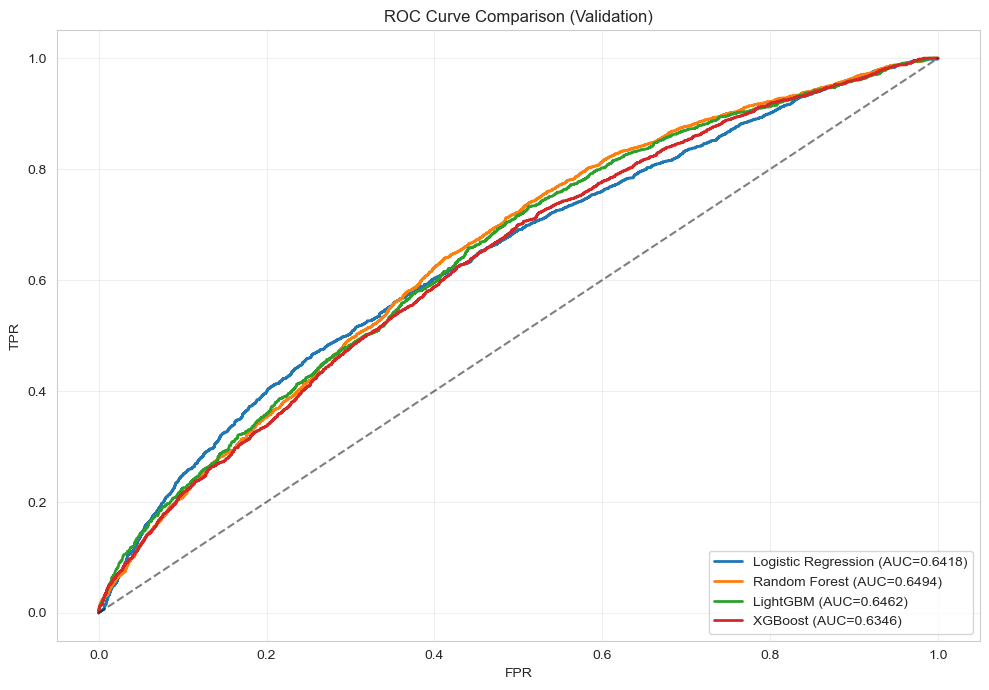

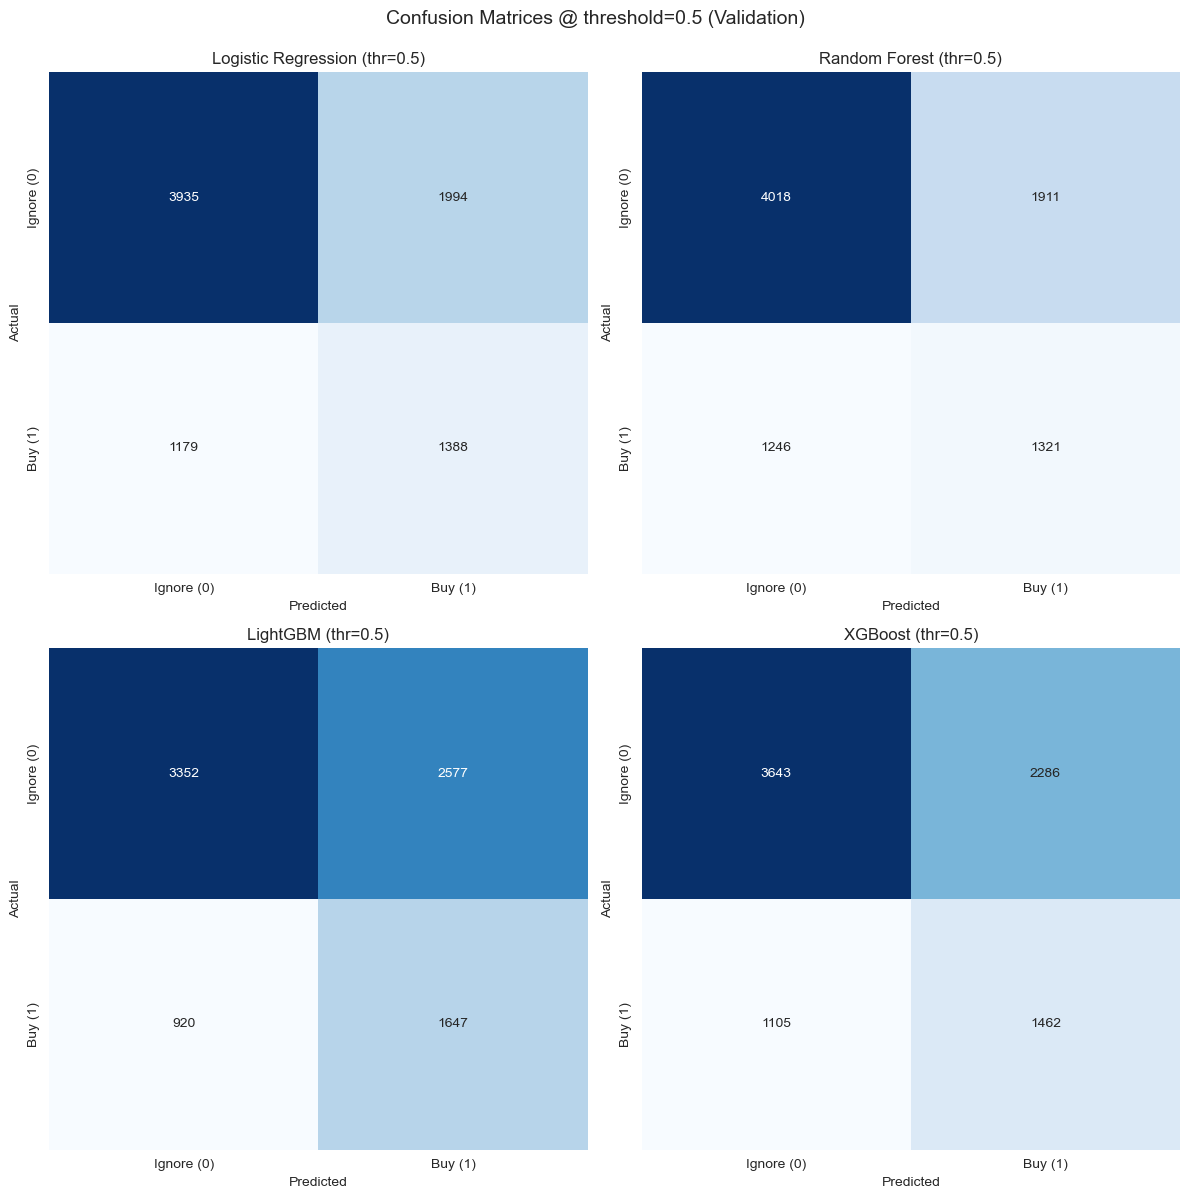

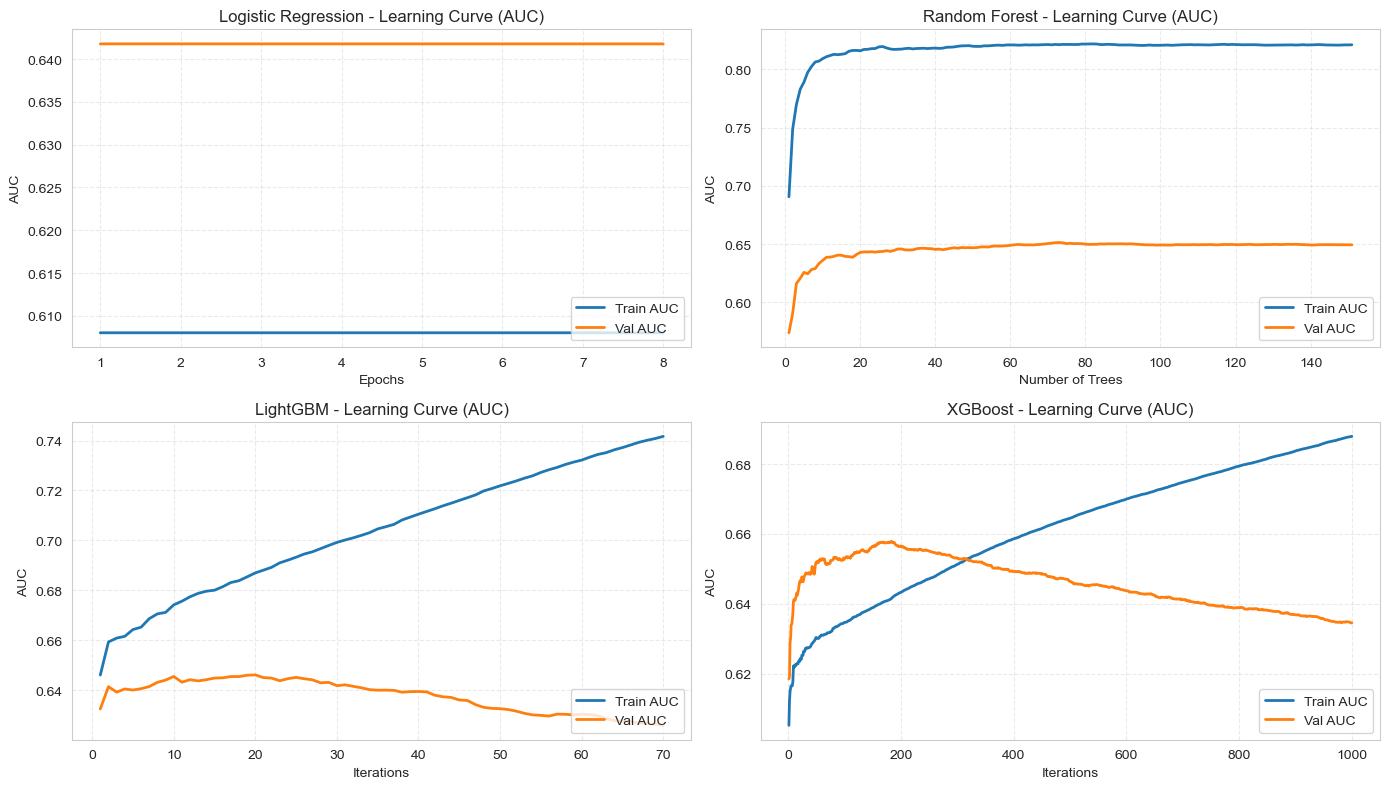

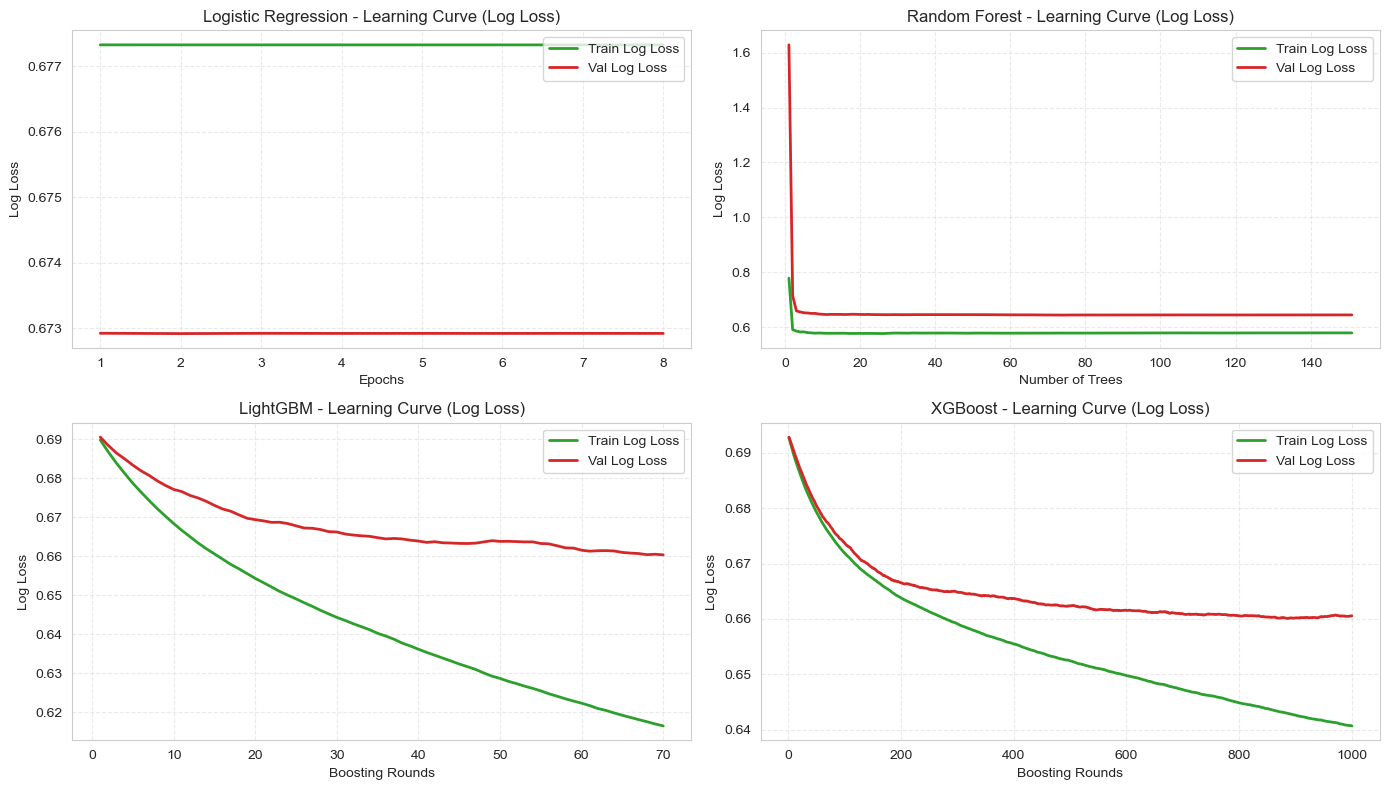

In [11]:
# ROC + Confusion Matrix + Metrics + Learning Curves (for all models)

# Collect per-model metrics at threshold=0.5
threshold = 0.5
summary_rows = []
conf_mats = {}
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost']

for name in model_names:
    if name not in model_results:
        continue
    res = model_results[name]
    y_scores = res['val_probs']
    y_pred = (y_scores >= threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    conf_mats[name] = cm

    # Metrics
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    auc = res['val_auc']

    summary_rows.append({
        'Model': name,
        'AUC': auc,
        'Precision@0.5': precision,
        'Recall@0.5': recall,
        'F1@0.5': f1,
        'Trades@0.5': int(y_pred.sum())
    })

metrics_df = pd.DataFrame(summary_rows).set_index('Model').sort_values('AUC', ascending=False)
print("Validation metrics @ threshold=0.5")
print(metrics_df)

# --- ROC ---
plt.figure(figsize=(10, 7))
for name in model_results.keys():
    y_scores = model_results[name]['val_probs']
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    auc_score = model_results[name]['val_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Comparison (Validation)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Confusion matrices ---
fig_cm, axes_cm = plt.subplots(2, 2, figsize=(12, 12))
axes_cm = axes_cm.ravel()
for ax, name in zip(axes_cm, model_names):
    if name not in conf_mats:
        ax.axis('off')
        continue
    cm = conf_mats[name]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ignore (0)', 'Buy (1)'],
                yticklabels=['Ignore (0)', 'Buy (1)'],
                cbar=False, ax=ax)
    ax.set_title(f'{name} (thr={threshold})')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
fig_cm.suptitle('Confusion Matrices @ threshold=0.5 (Validation)', y=0.995, fontsize=14)
plt.tight_layout()
plt.show()

# --- Learning curves  ---
fig_lc, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.ravel()

for ax, name in zip(axes, model_names):
    if name not in model_results:
        ax.axis('off')
        continue

    hist = model_results[name]['history']
    ax.set_title(f'{name} - Learning Curve (AUC)')
    ax.grid(True, linestyle='--', alpha=0.4)

    if hist is None or len(hist) == 0:
        ax.text(0.5, 0.5, 'Not iterative\n(no learning curve)', ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    xlabel = 'Iterations'
    if 'Logistic Regression' in name:
        xlabel = 'Epochs'
    elif 'Random Forest' in name:
        xlabel = 'Number of Trees'

    train_auc = hist.get('train_auc', [])
    val_auc = hist.get('val_auc', [])
    epochs = range(1, len(train_auc) + 1)

    ax.plot(epochs, train_auc, label='Train AUC', color='#1f77b4', linewidth=2)
    ax.plot(epochs, val_auc, label='Val AUC', color='#ff7f0e', linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('AUC')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# --- Learning curves (Log Loss) ---
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(14, 8))
axes_loss = axes_loss.ravel()

for ax, name in zip(axes_loss, model_names):
    if name not in model_results:
        ax.axis('off')
        continue

    hist = model_results[name]['history']
    ax.set_title(f'{name} - Learning Curve (Log Loss)')
    ax.grid(True, linestyle='--', alpha=0.4)

    if hist is None or len(hist.get('train_loss', [])) == 0:
        ax.text(0.5, 0.5, 'No loss history', ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    xlabel = 'Iterations'
    if 'Logistic Regression' in name:
        xlabel = 'Epochs'
    elif 'Random Forest' in name:
        xlabel = 'Number of Trees'
    elif 'LightGBM' in name or 'XGBoost' in name:
        xlabel = 'Boosting Rounds'

    train_loss = hist.get('train_loss', [])
    val_loss   = hist.get('val_loss', [])
    epochs = range(1, len(train_loss) + 1)

    ax.plot(epochs, train_loss, label='Train Log Loss', color='#2ca02c', linewidth=2)
    ax.plot(epochs, val_loss,   label='Val Log Loss',   color='#d62728', linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Log Loss')
    ax.legend(loc='upper right')

plt.tight_layout()


## 7. Những đặc trưng quan trọng nhất

In [12]:
# Các đặc trưng quan trọng nhất từ mô hình Random Forest
rf_final = model_results['Random Forest']['model']
importances = rf_final.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print("\nTop 10 Important Features from Tuned Random Forest:")
print(feature_importance_df.head(10))



Top 10 Important Features from Tuned Random Forest:
            Feature  Importance
0     volatility_20    0.079195
1          bb_width    0.074445
2               obv    0.063896
3      volume_ma_20    0.063828
4            atr_14    0.048127
5  ma_20_divergence    0.046591
6   ma_5_divergence    0.046201
7  ma_50_divergence    0.044845
8    macd_histogram    0.044682
9            volume    0.043114


## 8. Phân tích độ nhạy của ngưỡng

ĐANG TÌM NGƯỠNG TỐI ƯU CHO: Logistic Regression
 Threshold      Precision (Win Rate)     Recall (Capture)    # Trades (Val)
---------------------------------------------------------------------------
      0.60                    52.21%               22.98%              1130
      0.62                    53.26%               18.11%               873
      0.64                    54.68%               14.80%               695
      0.66                    54.05%               11.18%               531
      0.68                    55.32%                9.12%               423
      0.70                    54.15%                6.86%               325
      0.72                    53.54%                5.30%               254
      0.74                    54.79%                4.01%               188
      0.76                    52.24%                2.73%               134
---------------------------------------------------------------------------


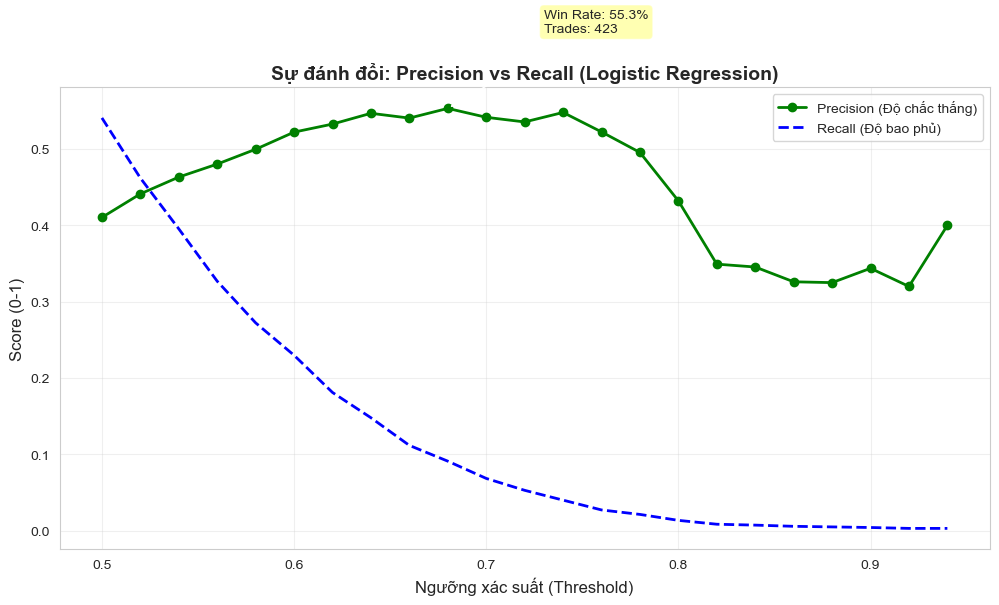

In [13]:
# 1. Lấy dữ liệu từ Model tốt nhất
winner_name = best_model_name
# Lấy xác suất dự báo trên tập Validation
y_probs_val = model_results[winner_name]['val_probs'] 
y_true_val = y_val

# 2. Chạy mô phỏng các ngưỡng từ 0.5 đến 0.95
thresholds = np.arange(0.50, 0.96, 0.02)
results = []

print(f"ĐANG TÌM NGƯỠNG TỐI ƯU CHO: {winner_name}")

# Bảng in có cột cố định (đều nhau)
col_w = (10, 25, 20, 17)
header = (
    f"{'Threshold':>{col_w[0]}} "
    f"{'Precision (Win Rate)':>{col_w[1]}} "
    f"{'Recall (Capture)':>{col_w[2]}} "
    f"{'# Trades (Val)':>{col_w[3]}}"
)
print(header)
print("-" * len(header))

best_threshold = 0.5
best_score = 0
min_trades = 10
for t in thresholds:
    y_pred_t = (y_probs_val >= t).astype(int)
    num_trades = y_pred_t.sum()

    if num_trades > 0:
        precision = precision_score(y_true_val, y_pred_t, zero_division=0)
        recall = recall_score(y_true_val, y_pred_t, zero_division=0)

        # In hàng với căn cột
        if precision > 0.5:
            print(
                f"{t:>{col_w[0]}.2f} "
                f"{precision:>{col_w[1]}.2%} "
                f"{recall:>{col_w[2]}.2%} "
                f"{num_trades:>{col_w[3]}d}"
            )

        results.append({
            'Threshold': t,
            'Precision': precision,
            'Recall': recall,
            'Trades': num_trades
        })

        if num_trades >= min_trades:
            if precision > best_score:
                best_score = precision
                best_threshold = t
            elif precision == best_score:
                pass

print("-" * len(header))

# 3. TRỰC QUAN HÓA SỰ ĐÁNH ĐỔI (TRADE-OFF)
df_thresh = pd.DataFrame(results)

if not df_thresh.empty:
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_thresh['Threshold'], df_thresh['Precision'], label='Precision (Độ chắc thắng)', color='green', linewidth=2, marker='o')
    plt.plot(df_thresh['Threshold'], df_thresh['Recall'], label='Recall (Độ bao phủ)', color='blue', linewidth=2, linestyle='--')
    
    
    plt.title(f'Sự đánh đổi: Precision vs Recall ({winner_name})', fontsize=14, fontweight='bold')
    plt.xlabel('Ngưỡng xác suất (Threshold)', fontsize=12)
    plt.ylabel('Score (0-1)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Thêm chú thích text
    best_row = df_thresh[df_thresh['Threshold'] == best_threshold].iloc[0]
    plt.annotate(f"Win Rate: {best_row['Precision']:.1%}\nTrades: {int(best_row['Trades'])}",
                 xy=(best_threshold, best_row['Precision']),
                 xytext=(best_threshold+0.05, best_row['Precision']+0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    plt.show()
else:
    print("Không tìm được ngưỡng nào khả thi (Model quá thận trọng hoặc data quá khó).")
